In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
# Load example data
full_wt_df = pd.read_csv('../data/sortseq/full-wt/data.txt',delim_whitespace=True)
rnap_wt_df = pd.read_csv('../data/sortseq/rnap-wt/data.txt',delim_whitespace=True)
crp_wt_df = pd.read_csv('../data/sortseq/crp-wt/data.txt',delim_whitespace=True)

# # Separate test from data_df
# ix_test = data_df['set']=='test'
# test_df = data_df[ix_test].reset_index(drop=True)
# print(f'test N: {len(test_df):,}')

# # Remove test data from data_df
# data_df = data_df[~ix_test].reset_index(drop=True)
# print(f'training + validation N: {len(data_df):,}')


In [3]:
data_df = full_wt_df.merge(rnap_wt_df,on='seq',how='outer').merge(crp_wt_df,on='seq',how='outer').fillna(0)

In [4]:
y_cols = list(np.arange(0,30,1).astype(str))
cols = list(np.arange(0,30,1).astype(str))
cols.insert(0,'x')
data_df.columns = cols

In [5]:
X = data_df['x']
y = data_df[y_cols]

In [6]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A','C','G','T']

#y_cols = data_df.columns[1:-1]
Y = len(y_cols)
print(f'L={L}, Y={Y}')

# get test set data.

L=75, Y=30


In [8]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

#therodynamic_gpmap = ThermodynamicLayer(alphabet=alphabet,**gpmap_kwargs)

2022-05-24 20:37:16.331394: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# I think this shouldn't require any positional arguments.
# mp_GE = mavenn.measurement_process_layers.GlobalEpistasisLayer(K=50,
#                                                                eta=1e-5,
#                                                                monotonic=True)
mp_mpa_1 = mavenn.measurement_process_layers.DiscreteAgnosticMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=10,
                                                                      K=50,
                                                                      eta=1e-5,)

mp_mpa_2 = mavenn.measurement_process_layers.DiscreteAgnosticMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=10,
                                                                      K=50,
                                                                      eta=1e-5,)

mp_mpa_3 = mavenn.measurement_process_layers.DiscreteAgnosticMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=10,
                                                                      K=50,
                                                                      eta=1e-5,)


In [10]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=[mp_mpa_1, mp_mpa_2, mp_mpa_3])

inputs in build shape = (None, 11)
inputs in build shape = (None, 11)
inputs in build shape = (None, 11)


In [11]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 330)]       0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 300)          0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           301         ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [12]:
#x_train,y_train
y_train[y_cols[0:10]]

,0,1,2,3,4,5,6,7,8,9
31853,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
132792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44508,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
99643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
94557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43873,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
121283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Set training data
model.set_data(x=x_train,
               y_list=[y_train[y_cols[0:10]].values,y_train[y_cols[10:20]].values,y_train[y_cols[20:30]].values],
               #validation_flags=(data_df['set']=='validation'),
               shuffle=False)

N = 111,432 observations set as training data.
Using 19.9% for validation.
Time to set data: 7.2 sec.


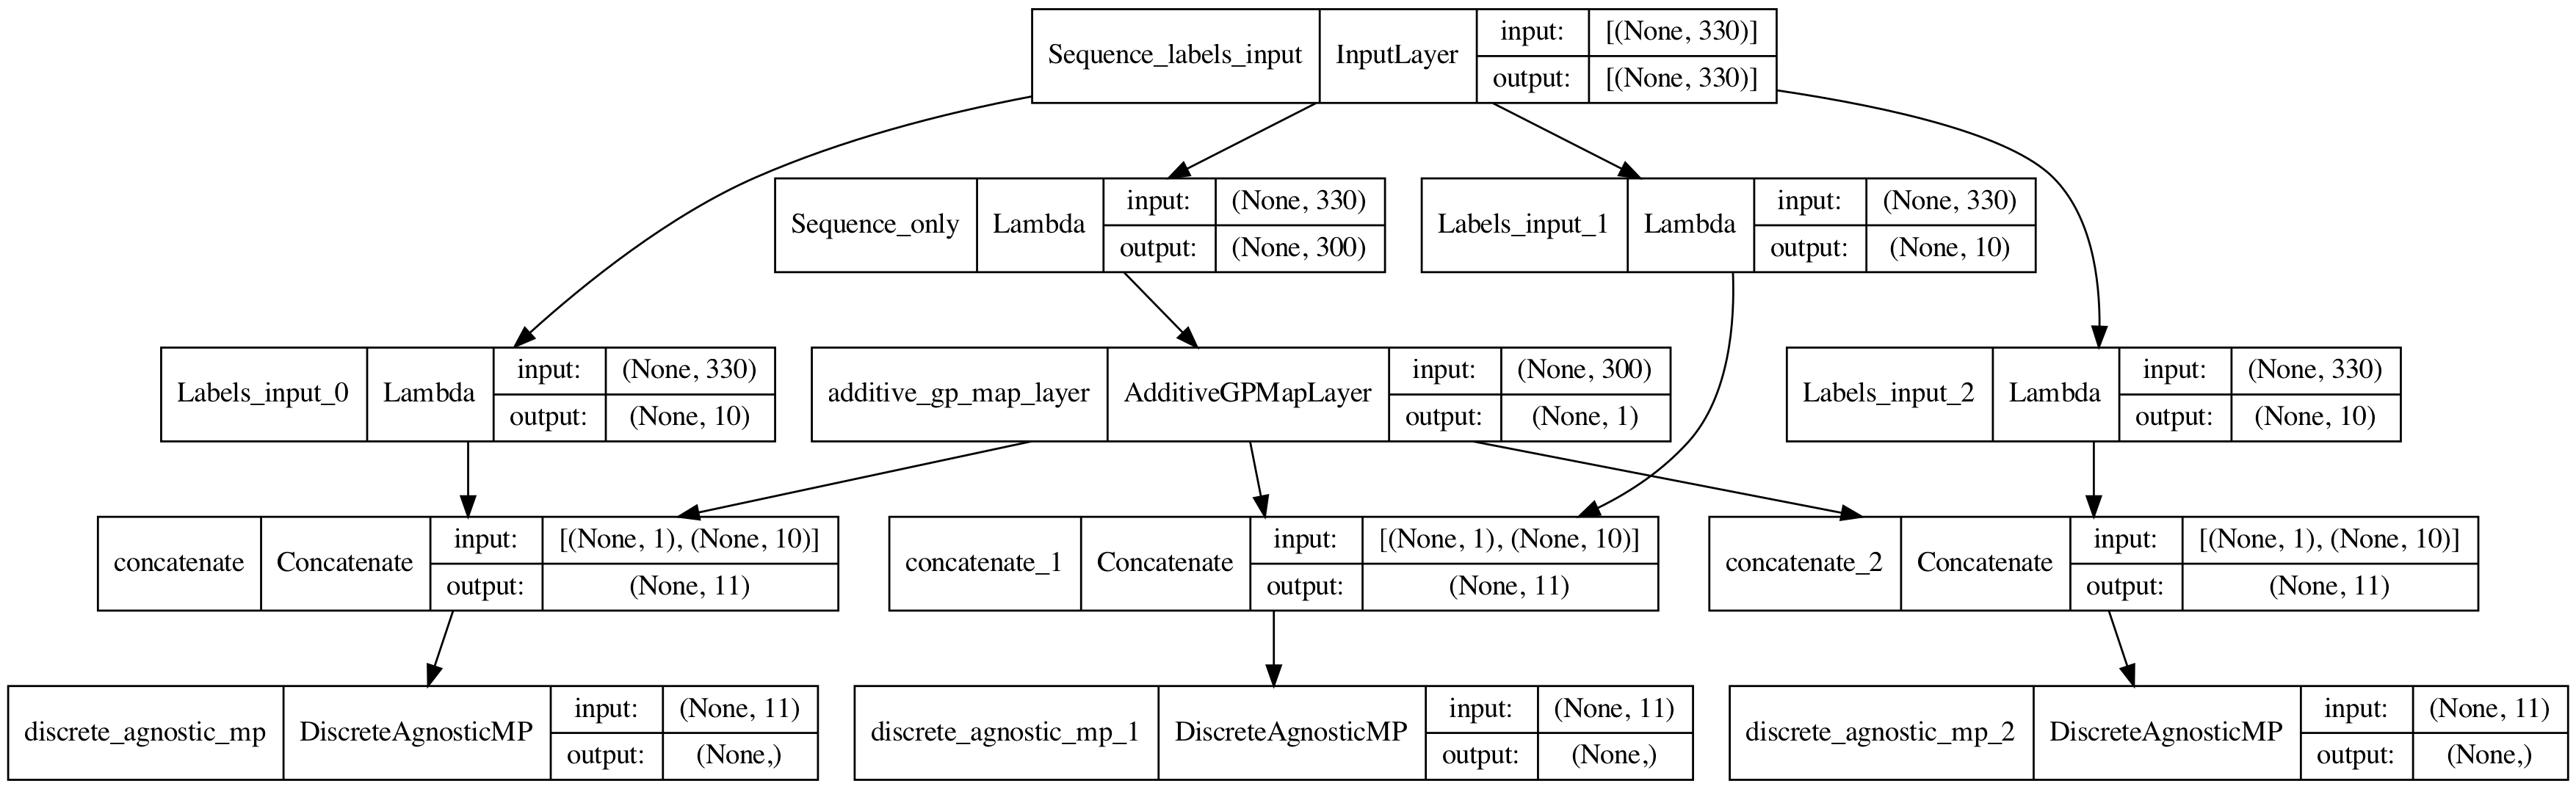

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=200,to_file='multiheaded_discrete_agnostic_30_bins.png')

In [15]:

# Fit model to data
model.fit(learning_rate=.005,
          epochs=50,
          batch_size=1000,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/50
90/90 [==============================] - 11s 41ms/step - loss: 3016.5383 - discrete_agnostic_mp_loss: 1090.4126 - discrete_agnostic_mp_1_loss: 973.0781 - discrete_agnostic_mp_2_loss: 953.0237 - I_var: 0.2556 - val_loss: 2696.0447 - val_discrete_agnostic_mp_loss: 972.0287 - val_discrete_agnostic_mp_1_loss: 862.9885 - val_discrete_agnostic_mp_2_loss: 860.9990 - val_I_var: 0.5399
Epoch 2/50
90/90 [==============================] - 2s 26ms/step - loss: 2619.9453 - discrete_agnostic_mp_loss: 956.9926 - discrete_agnostic_mp_1_loss: 822.2419 - discrete_agnostic_mp_2_loss: 840.6770 - I_var: 0.6130 - val_loss: 2627.9463 - val_discrete_agnostic_mp_loss: 941.0941 - val_discrete_agnostic_mp_1_loss: 820.6719 - val_discrete_agnostic_mp_2_loss: 866.1425 - val_I_var: 0.5259
Epoch 3/50
90/90 [==============================] - 2s 25ms/step - loss: 2571.3958 - discrete_agnostic_mp_loss: 938.8124 - discrete_agnostic_mp_1_loss: 799.8712 - discrete_agnostic_mp_2_loss: 832.6711 - I_var: 0.6382 - v

90/90 [==============================] - 3s 31ms/step - loss: 2455.8655 - discrete_agnostic_mp_loss: 906.6682 - discrete_agnostic_mp_1_loss: 752.4786 - discrete_agnostic_mp_2_loss: 796.6186 - I_var: 0.7540 - val_loss: 2448.5010 - val_discrete_agnostic_mp_loss: 894.9062 - val_discrete_agnostic_mp_1_loss: 741.5745 - val_discrete_agnostic_mp_2_loss: 811.9196 - val_I_var: 0.6950
Epoch 23/50
90/90 [==============================] - 3s 31ms/step - loss: 2451.1140 - discrete_agnostic_mp_loss: 906.2272 - discrete_agnostic_mp_1_loss: 750.0389 - discrete_agnostic_mp_2_loss: 794.7474 - I_var: 0.7585 - val_loss: 2433.6973 - val_discrete_agnostic_mp_loss: 890.7432 - val_discrete_agnostic_mp_1_loss: 738.5740 - val_discrete_agnostic_mp_2_loss: 804.2789 - val_I_var: 0.7204
Epoch 24/50
90/90 [==============================] - 3s 34ms/step - loss: 2453.9702 - discrete_agnostic_mp_loss: 906.3772 - discrete_agnostic_mp_1_loss: 752.2229 - discrete_agnostic_mp_2_loss: 795.2685 - I_var: 0.7586 - val_loss: 24

90/90 [==============================] - 3s 31ms/step - loss: 2452.7061 - discrete_agnostic_mp_loss: 905.1591 - discrete_agnostic_mp_1_loss: 751.5579 - discrete_agnostic_mp_2_loss: 795.8763 - I_var: 0.7548 - val_loss: 2445.1794 - val_discrete_agnostic_mp_loss: 896.9046 - val_discrete_agnostic_mp_1_loss: 737.7134 - val_discrete_agnostic_mp_2_loss: 810.4485 - val_I_var: 0.7055
Epoch 44/50
90/90 [==============================] - 3s 31ms/step - loss: 2455.9551 - discrete_agnostic_mp_loss: 907.6463 - discrete_agnostic_mp_1_loss: 752.1362 - discrete_agnostic_mp_2_loss: 796.0585 - I_var: 0.7561 - val_loss: 2434.4785 - val_discrete_agnostic_mp_loss: 893.3353 - val_discrete_agnostic_mp_1_loss: 734.3600 - val_discrete_agnostic_mp_2_loss: 806.6690 - val_I_var: 0.7149
Epoch 45/50
90/90 [==============================] - 3s 28ms/step - loss: 2449.2283 - discrete_agnostic_mp_loss: 906.8228 - discrete_agnostic_mp_1_loss: 749.2662 - discrete_agnostic_mp_2_loss: 793.0239 - I_var: 0.7622 - val_loss: 24

On test data:


Text(0.5, 1.0, 'training hisotry')

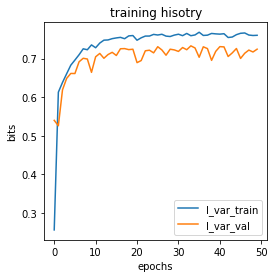

In [16]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

In [17]:
phi = gpmap.x_to_phi(x_test)

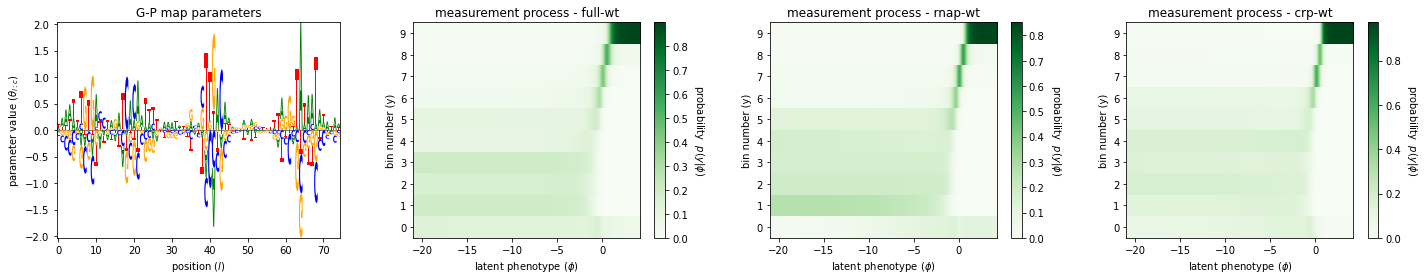

In [19]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
#phi_lim = [-5, 3]
phi_lim = [min(phi), max(phi)]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = 10    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process_1 = mp_mpa_1.p_of_y_given_phi(y_all, phi_grid)
measurement_process_2 = mp_mpa_2.p_of_y_given_phi(y_all, phi_grid)
measurement_process_3 = mp_mpa_3.p_of_y_given_phi(y_all, phi_grid)

#measurement_process = np.hstack([measurement_process_1,measurement_process_2,measurement_process_3])

# Create figure with two panels
fig, axs = plt.subplots(1,4,figsize=[20,4])

# Left panel: draw logo using logomaker
ax = axs[0]
logo = logomaker.Logo(pd.DataFrame(theta,columns=model.alphabet), ax=ax,center_values=True)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters')

ax = axs[1]
im = ax.imshow(measurement_process_1,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process - full-wt')
cb = plt.colorbar(im,ax=ax)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

ax = axs[2]
im = ax.imshow(measurement_process_2,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process - rnap-wt')
cb = plt.colorbar(im,ax=ax)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")


ax = axs[3]
im = ax.imshow(measurement_process_3,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process - crp-wt')
cb = plt.colorbar(im,ax=ax)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")


# Fix up plot
fig.tight_layout(w_pad=3)
fig.savefig('sortseq_multiheaded_discrete_agnostic_visualization.png',dpi=200,bbox_inches='tight')
plt.show()